# XBeach data demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from rompy_xbeach.grid import Ori, RegularGrid

import warnings
warnings.filterwarnings("ignore")

/home/rguedes/.virtualenvs/xbeach/lib/python3.10/site-packages/pyschism/forcing/hycom/gofs.py:8: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


## Read bathy

Read bathy from the test data to inspect and help defining the model grid

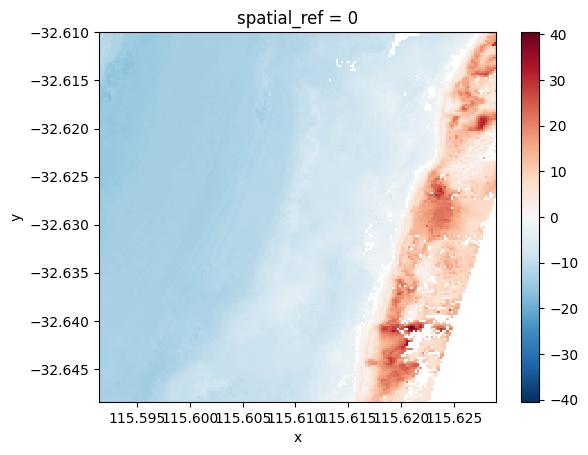

In [3]:
bathy = rioxarray.open_rasterio("../../../rompy-xbeach/tests/data/bathy.tif")
bathy = bathy.isel(band=0, drop=True)
bathy.plot()

## Set the grid

Define the XBeach grid object in `EPSG:28350` projection (use latlon to specify the origin)

In [9]:
grid = RegularGrid(
    ori=Ori(
        x=115.594239,
        y=-32.641104,
        crs="epsg:4326",
    ),
    alfa=347,
    dx=10,
    dy=15,
    nx=230,
    ny=220,
    crs="28350",
)

### Plot grid on bathy

The origin and rotation of the grid needs to be defined such that the offshore boundary
of the interpolated bathymetry data corresponds to the first row and column. The `grid.plot()`
method highlights the origin and offshore boundary in red to assist with the grid definition

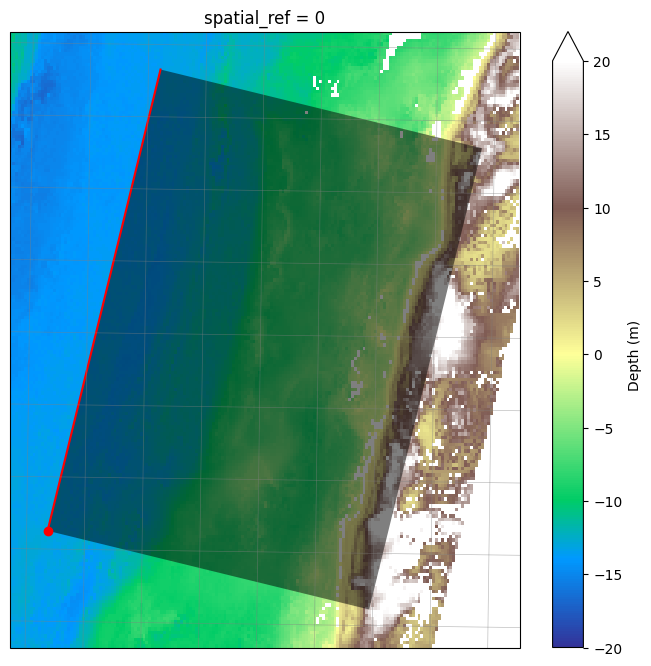

In [7]:
projection = ccrs.Stereographic(
    central_longitude=grid.ori.x, central_latitude=grid.ori.y
)
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(8.5, 8))

# Bathymetry
bathy.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="terrain",
    vmin=-20,
    vmax=20,
    cbar_kwargs=dict(label="Depth (m)"),
)

# Grid
ax = grid.plot(
    ax=ax,
    buffer=250,
    grid_kwargs=dict(facecolor="k", alpha=0.5, zorder=2),
    show_offshore=True,
    show_origin=True,
)

<div class="alert alert-block alert-warning">
⚠️ Here we will define another grid by poorly selecting the origin and rotation
</div>

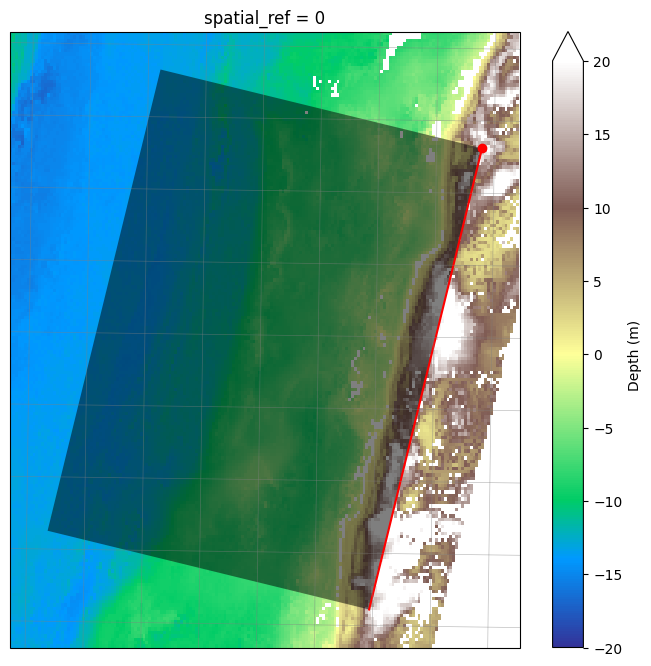

In [8]:
# Define origin at the NE corner of the existing grid
x0 = grid.x[-1, -1]
y0 = grid.y[-1, -1]

# Notice we are now specifying the origin in projected coordinates!
grid_bad = RegularGrid(
    ori=Ori(x=x0, y=y0, crs=28350),
    alfa=347-180,
    dx=10,
    dy=15,
    nx=230,
    ny=220,
    crs="28350",
)

# Plotting
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(8.5, 8))
bathy.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="terrain",
    vmin=-20,
    vmax=20,
    cbar_kwargs=dict(label="Depth (m)"),
)
ax = grid_bad.plot(ax=ax, buffer=250, grid_kwargs=dict(facecolor="k", alpha=0.5, zorder=2))

## Set Data object

Define the data with a `SourceGeotiff` source and use the grid created above to create the model files

In [10]:
from rompy_xbeach.source import SourceGeotiff
from rompy_xbeach.data import XBeachBathy, SeawardExtensionLinear
from rompy_xbeach.interpolate import RegularGridInterpolator

### Example 1: no extension of the grid

#### Instantiate the data object

In [25]:
# First we define source and interpolator instances

source = SourceGeotiff(filename="../../../rompy-xbeach/tests/data/bathy.tif")

interpolator = RegularGridInterpolator(
    kwargs=dict(
        method="linear",
        fill_value=None,
    ),
)

In [26]:
data = XBeachBathy(
    source=source,
    posdwn=False,
    interpolator=interpolator,
)

#### Interpolate onto the model grid

In [13]:
workspace = Path("./example1")
workspace.mkdir(exist_ok=True)

xfile1, yfile1, datafile1, grid1 = data.get(destdir=workspace, grid=grid)
sorted(workspace.glob("*.txt"))

INFO:rompy_xbeach.data:Reprojecting ../../../rompy-xbeach/tests/data/bathy.tif to EPSG:28350


[PosixPath('example1/data.txt'),
 PosixPath('example1/xdata.txt'),
 PosixPath('example1/ydata.txt')]

### Plot the interpolated data

In [14]:
def plot_model_bathy(xfile, yfile, datafile, grid):
    # Read the generated files
    x = np.loadtxt(xfile)
    y = np.loadtxt(yfile)
    data = np.loadtxt(datafile)

    fig, axs = plt.subplots(1, 2, subplot_kw={"projection": projection}, figsize=(15, 8))

    # Plot in real coordinates
    ax = axs[0]
    ax.pcolormesh(x, y, data, transform=grid.transform, vmin=-20, vmax=20, cmap="terrain")
    ax = grid.plot(
        ax=ax,
        buffer=250,
        grid_kwargs=dict(edgecolor="k", facecolor="none"),
        show_mesh=True,
        mesh_step=10,
    )
    # ax.plot(grid.x0, grid.y0, "ro", transform=grid.transform)
    ax.set_title("Real coordinates")

    # Plot in model coordinates
    ax = axs[1]
    x = np.arange(grid.nx) * grid.dx
    y = np.arange(grid.ny) * grid.dy
    p = ax.pcolormesh(x, y, data, vmin=-20, vmax=20, cmap="terrain")
    plt.colorbar(p)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.axis("equal")
    ax.set_title("Model coordinates")

    return x, y, data

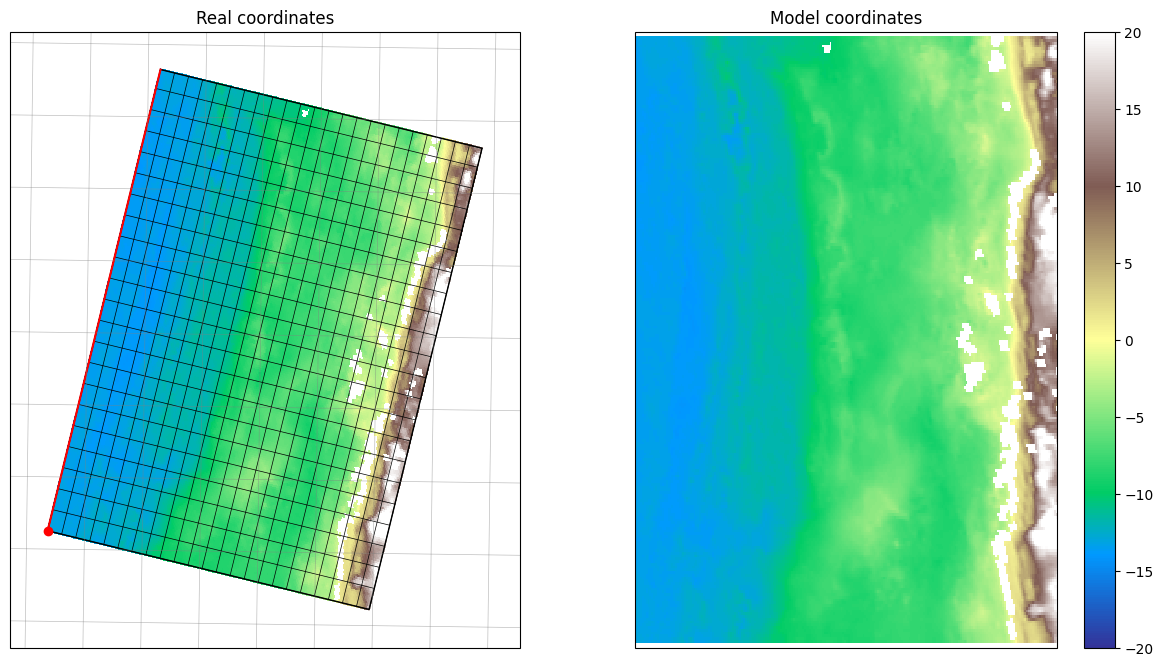

In [15]:
x1, y1, data1 = plot_model_bathy(xfile1, yfile1, datafile1, grid1)

### Example 2: Extend offshore boundary

#### Instantiate the data object

In [28]:
# The offshore extension is prescribed using one of the SeawardExtionsion subclasses

extension = SeawardExtensionLinear(
    depth=25,
    slope=0.1,
)

In [29]:
data = XBeachBathy(
    source=source,
    posdwn=False,
    interpolator=interpolator,
    extension=extension,
)

In [30]:
workspace = Path("./example2")
workspace.mkdir(exist_ok=True)

xfile2, yfile2, datafile2, grid2 = data.get(destdir=workspace, grid=grid)
sorted(workspace.glob("*.txt"))

INFO:rompy_xbeach.data:Reprojecting ../../../rompy-xbeach/tests/data/bathy.tif to EPSG:28350


[PosixPath('example2/data.txt'),
 PosixPath('example2/xdata.txt'),
 PosixPath('example2/ydata.txt')]

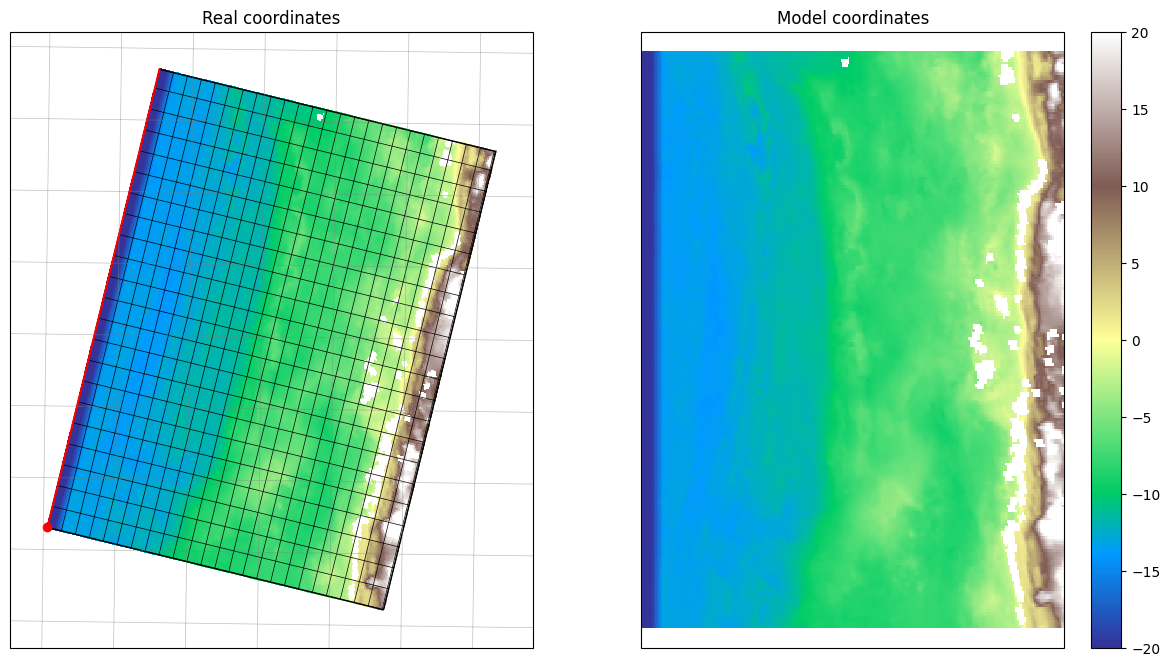

In [31]:
x2, y2, data2 = plot_model_bathy(xfile2, yfile2, datafile2, grid2)

In [32]:
print(data1.shape)
print(data2.shape)

(220, 230)
(220, 242)


#### The less the slope the longer the extension

In [34]:
extension = SeawardExtensionLinear(
    depth=25,
    slope=0.02,
)

data = XBeachBathy(
    source=source,
    posdwn=False,
    interpolator=interpolator,
    extension=extension,
)

xfile3, yfile3, datafile3, grid3 = data.get(destdir=workspace, grid=grid)

INFO:rompy_xbeach.data:Reprojecting ../../../rompy-xbeach/tests/data/bathy.tif to EPSG:28350


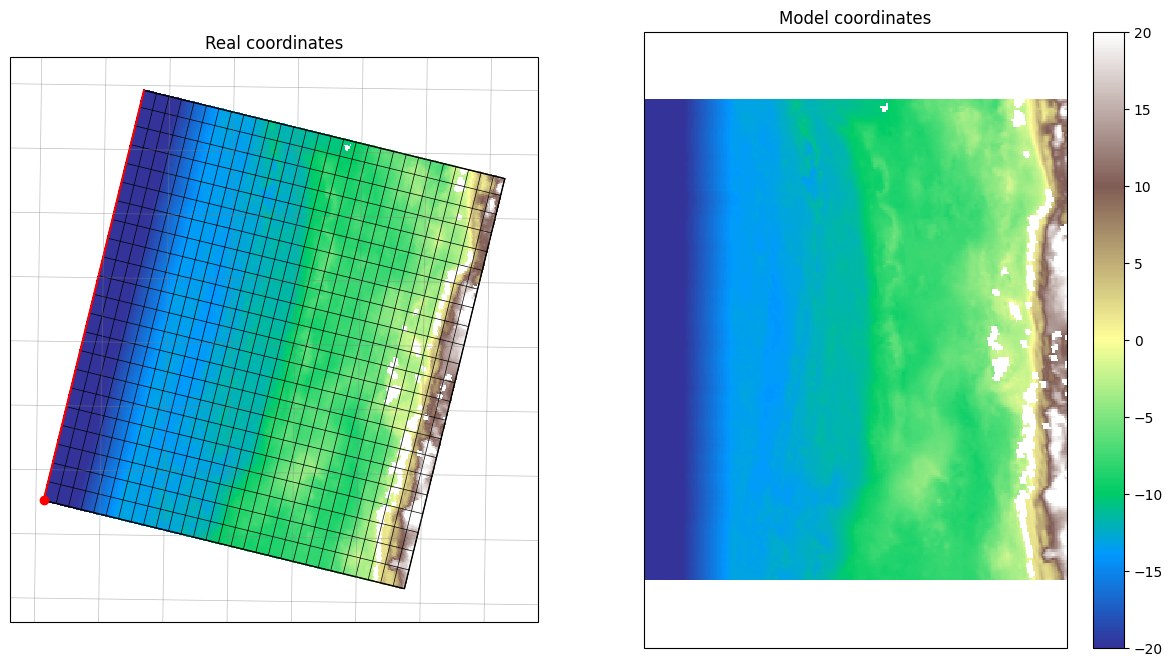

In [35]:
x3, y3, data3 = plot_model_bathy(xfile3, yfile3, datafile3, grid3)